In [10]:
#Import all the required packages
import pandas as pd
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

data = pd.read_excel("C:/Users/me/Desktop/Online Retail.xlsx")
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [11]:
import seaborn as sns
sns.set_palette("husl")
sns.set(rc={'image.cmap': 'coolwarm'})

In [12]:
#Append new column 
import datetime as dt
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate']).dt.date

In [13]:
data = data[pd.notnull(data['CustomerID'])]
data = data[(data['Quantity']>0)]

In [14]:
data['Sales'] = data['Quantity'] * data['UnitPrice']
cols_of_interest = ['CustomerID', 'InvoiceDate', 'Sales']
data = data[cols_of_interest]

In [15]:
print(data.head())
print(data['CustomerID'].nunique())

   CustomerID InvoiceDate  Sales
0     17850.0  2010-12-01  15.30
1     17850.0  2010-12-01  20.34
2     17850.0  2010-12-01  22.00
3     17850.0  2010-12-01  20.34
4     17850.0  2010-12-01  20.34
4339


In [16]:
from lifetimes.plotting import *
from lifetimes.utils import *
from lifetimes.estimation import *
# T corresponds to the time between their first purchase and now (their “lifetime” as a customer of yours).
sale = summary_data_from_transaction_data(data, 'CustomerID', 'InvoiceDate', monetary_value_col='Sales', observation_period_end='2011-12-9')
sale.head()


,frequency,recency,T,monetary_value
CustomerID,,,,
12346.0,0.0,0.0,325.0,0.000000
12347.0,6.0,365.0,367.0,599.701667
12348.0,3.0,283.0,358.0,301.480000
12349.0,0.0,0.0,18.0,0.000000
12350.0,0.0,0.0,310.0,0.000000


count    4339.000000
mean        2.864024
std         5.952745
min         0.000000
25%         0.000000
50%         1.000000
75%         3.000000
max       131.000000
Name: frequency, dtype: float64
0.356994699239


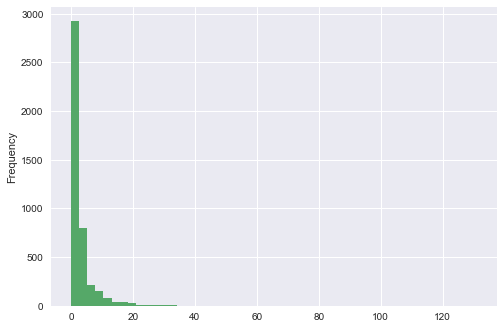

In [17]:
# Creating a histogram for the frequency distribution of the data to get a proper view of the data distribution
sale['frequency'].plot(kind='hist', bins=50)
print(sale['frequency'].describe())
print(sum(sale['frequency'] == 0)/float(len(sale)))
plt.show()

In [18]:
from lifetimes import BetaGeoFitter

# similar API to scikit-learn and lifelines.
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(sale['frequency'], sale['recency'], sale['T'])
print(bgf)

<lifetimes.BetaGeoFitter: fitted with 4339 subjects, a: 0.00, alpha: 68.94, b: 2.16, r: 0.83>


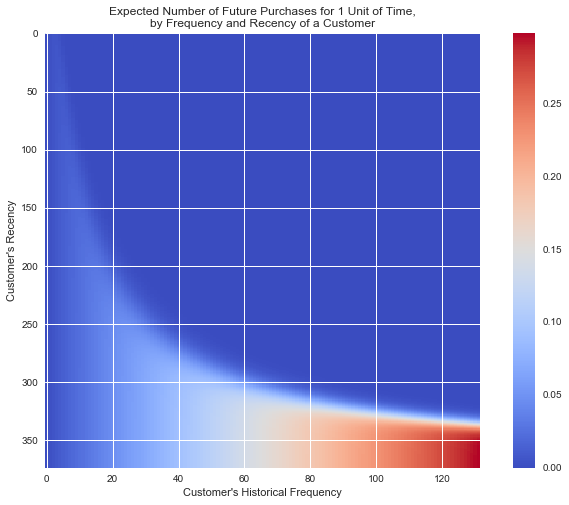

In [19]:
#ploting the frequency recency matrix.
#It computes the expected number of transactions a artifical customer is to make in the next time period.
#It give his or her recency (age at last purchase) and frequency (the number of repeat transactions he or she has made)

from lifetimes.plotting import plot_frequency_recency_matrix
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12,8))
plot_frequency_recency_matrix(bgf)
plt.show()

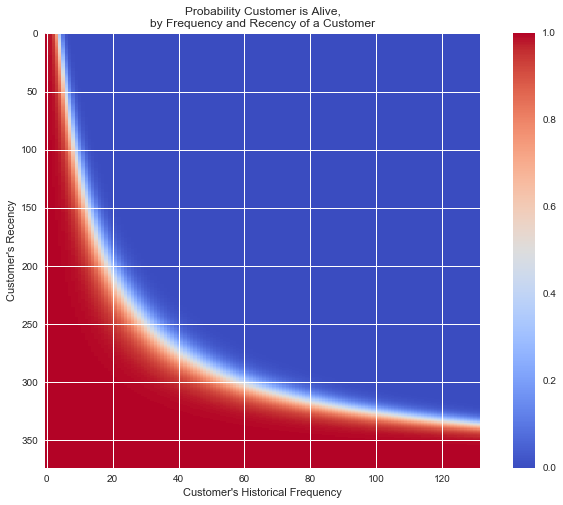

In [20]:
# Here (20,120) that represents the customer who buys infrequently, but we've seen him or her recently, so they might buy again - we're not sure if they are dead or just between purchases.
from lifetimes.plotting import plot_probability_alive_matrix
fig = plt.figure(figsize=(12,8))
plot_probability_alive_matrix(bgf)
plt.show()

In [21]:
#Ranking customers from best to worst
#Customer rank from "highest expected purchases in the next period" to lowest. Models expose a method that will predict a customer's expected purchases in the next period using their history
#Great, we can see that the customer who has made 131 purchases, and bought very recently from us, is probably going to buy again in the next period.
t = 1
sale['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, sale['frequency'], sale['recency'], sale['T'])
sale.sort_values(by='predicted_purchases').tail(5)

,frequency,recency,T,monetary_value,predicted_purchases
CustomerID,,,,,
14606.0,88.0,372.0,373.0,135.890114,0.200991
15311.0,89.0,373.0,373.0,677.729438,0.203254
17841.0,111.0,372.0,373.0,364.452162,0.253034
12748.0,113.0,373.0,373.0,298.360885,0.257560
14911.0,131.0,372.0,373.0,1093.661679,0.298289


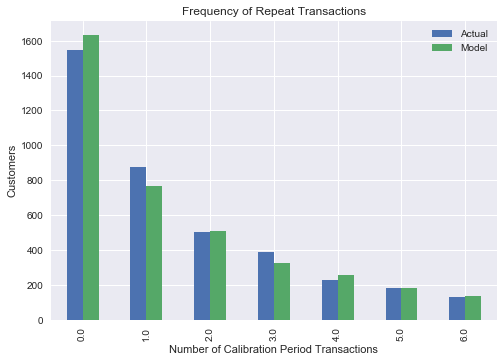

In [22]:
# Visualize our customers' behaviour, but is our model correct? There are a few ways to assess the model's correctness
# Now compare given data versus artifical data simulated with  fitted model's parameters.
from lifetimes.plotting import plot_period_transactions
plot_period_transactions(bgf)
plt.show()
# The plot give the clear indicationthat our actual data and our simulated data line up well.
#This proves that our model doesn't suck.

In [23]:
# Utility functions to transform that transactional data (one row per purchase) into summary data (a frequency, recency and age dataset). 
from lifetimes.utils import calibration_and_holdout_data

summary_cal_holdout = calibration_and_holdout_data(data, 'CustomerID', 'InvoiceDate',
                                        calibration_period_end='2011-06-08',
                                        observation_period_end='2011-12-9' )   
print(summary_cal_holdout.head())

            frequency_cal  recency_cal  T_cal  frequency_holdout  \
CustomerID                                                         
12346.0               0.0          0.0  141.0                0.0   
12347.0               2.0        121.0  183.0                4.0   
12348.0               2.0        110.0  174.0                1.0   
12350.0               0.0          0.0  126.0                0.0   
12352.0               3.0         34.0  112.0                3.0   

            duration_holdout  
CustomerID                    
12346.0                  184  
12347.0                  184  
12348.0                  184  
12350.0                  184  
12352.0                  184  


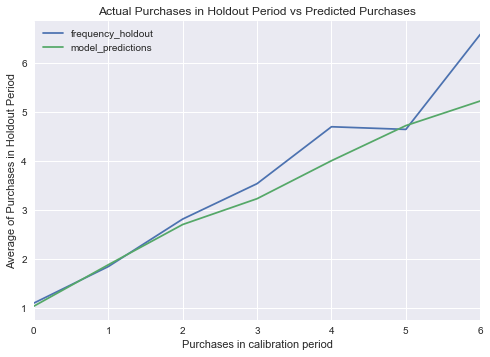

In [24]:
# model fitting
# With transactional data, we can partition the dataset into a calibration period dataset and a holdout dataset, to test how our model performs on data not yet seen (think cross-validation in standard machine learning literature). Lifetimes has a function to partition our dataset like this:The plot showing actual purchase in holdout period versus predicted purchase
# We can peroform fitting on the _cal columns, and test on the _holdout columns:
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases

bgf.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])
plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout)
plt.show()

In [25]:
# Basic on customer history, we can predict what an individuals future purchases might look like:
t = 10 #predict purchases in 10 periods
individual = sale.loc[12347]
# The below function is an alias to `bfg.conditional_expected_number_of_purchases_up_to_time`
bgf.predict(t, individual['frequency'], individual['recency'], individual['T'])

0.157277149444185

In [26]:
sale.loc[12347]

frequency                6.000000
recency                365.000000
T                      367.000000
monetary_value         599.701667
predicted_purchases      0.015657
Name: 12347.0, dtype: float64

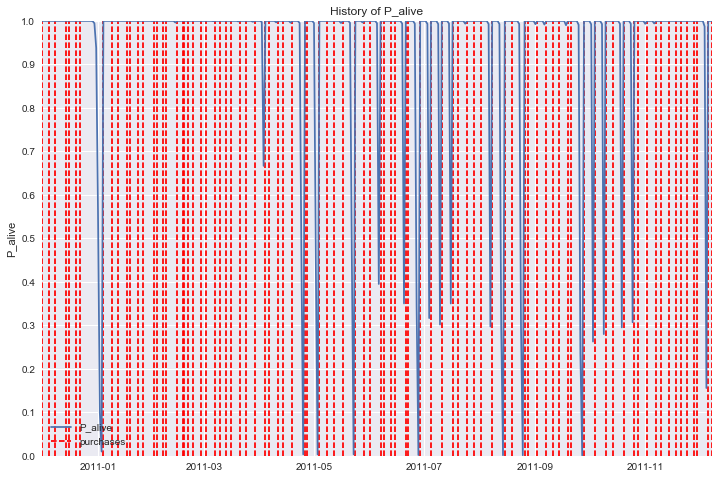

In [27]:
from lifetimes.plotting import plot_history_alive
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,8))
id = 14606
days_since_birth = 365
sp_trans = data.loc[data['CustomerID'] == id]
plot_history_alive(bgf, days_since_birth, sp_trans, 'InvoiceDate')
plt.show()

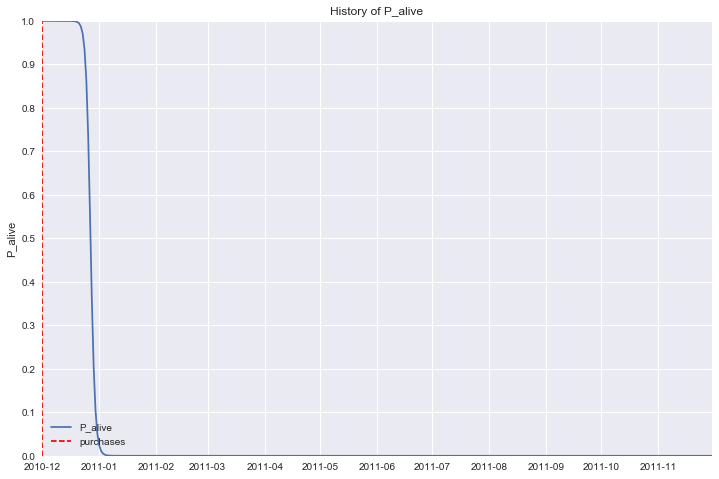

In [28]:
fig = plt.figure(figsize=(12,8))
id = 14729
days_since_birth = 365
sp_trans = data.loc[data['CustomerID'] == id]
plot_history_alive(bgf, days_since_birth, sp_trans, 'InvoiceDate')
plt.show()


In [29]:
returning_customers_summary = sale[sale['frequency']>0]

print(returning_customers_summary.head())
print(len(returning_customers_summary))

            frequency  recency      T  monetary_value  predicted_purchases
CustomerID                                                                
12347.0           6.0    365.0  367.0      599.701667             0.015657
12348.0           3.0    283.0  358.0      301.480000             0.008957
12352.0           6.0    260.0  296.0      368.256667             0.018700
12356.0           2.0    303.0  325.0      269.905000             0.007172
12358.0           1.0    149.0  150.0      683.200000             0.008339
2790


In [30]:
returning_customers_summary[['monetary_value', 'frequency']].corr()

,monetary_value,frequency
monetary_value,1.000000,0.015882
frequency,0.015882,1.000000


In [31]:
# Now building a gamma gamma model to predict average transaction value for each customer
from lifetimes import GammaGammaFitter

ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(returning_customers_summary['frequency'],
        returning_customers_summary['monetary_value'])
print(ggf)

<lifetimes.GammaGammaFitter: fitted with 2790 subjects, p: 2.10, q: 3.45, v: 485.57>


In [32]:
# Predicted the average transaction value for each customer
print(ggf.conditional_expected_average_profit(
        sale['frequency'],
        sale['monetary_value']
    ).head(10))

CustomerID
12346.0    416.917654
12347.0    569.988799
12348.0    333.762674
12349.0    416.917654
12350.0    416.917654
12352.0    376.166863
12353.0    416.917654
12354.0    416.917654
12355.0    416.917654
12356.0    324.008944
dtype: float64
